In [1]:
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid
# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)



#Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Hyperparameters
GENERATOR_LEARNING_RATE = 0.0001
DISCRIMINATOR_LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 500
N_CRITIC=5
c_lambda = 10
noise_dim=50
beta_1 = 0
beta_2 = 0.999


normalize_transform = transforms.Compose([
    
    transforms.Normalize((0.5,), (0.5,))  # Normalizes grayscale values to the range [-1, 1]
])

#****************************************Dataset loading*********************************************
# Load metasurfaces
image_file = "Gen2_datasets/No_MNIST_NO_GENERATED.txt" #Test_metasurface_V1 Final_metasurface_V6 #No_MNIST_NO_GENERATED
def process_image_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    images = []
    image = []
    for line in lines:
        row = [int(pixel) for pixel in line.strip().split(',')]
        image.append(row)
        if len(image) == 64:
            images.append(image)
            image = []
    images = np.array(images, dtype=np.float32)
    images = images.reshape(-1, 1, 64, 64)  
    return images

images = process_image_file(image_file)
#print(f"Loaded Images Shape: {images.shape}")

def parse_complex_number(s):
    s = s.replace("+-", "-")  # Ensure proper formatting

    # Case 1: Complex number with real and imaginary parts (e.g., "-0.2951-0.4833i")
    complex_match = re.match(r'([+-]?\d*\.?\d+)([+-]\d*\.?\d+)i$', s)
    if complex_match:
        real_part = float(complex_match.group(1))  
        imag_part = float(complex_match.group(2))  
        return complex(real_part, imag_part)

    # Case 2: Pure imaginary number (e.g., "0.0i", "-0.0i")
    imag_match = re.match(r'([+-]?\d*\.?\d+)i$', s)
    if imag_match:
        return complex(0.0, float(imag_match.group(1)))

    # Case 3: Pure real number (e.g., "0", "-0", "0.0")
    real_match = re.match(r'([+-]?\d*\.?\d+|0)$', s)
    if real_match:
        return complex(float(real_match.group(1)), 0.0)

    raise ValueError(f"Invalid complex number format: {s}")

# -----------------------------------
# Load & Parse Complex Spectra Data
# -----------------------------------
spectra_file = "Gen2_datasets/No_MNIST_NO_GENERATED_Complex.txt"   #Test_label_complex_V1 Final_label_complex_V6 No_MNIST_NO_GENERATED_Complex

with open(spectra_file, 'r') as file:
    lines = file.readlines()

# Convert each string number into a complex number
complex_numbers = []
for line in lines:
    for num in line.strip().split():
        try:
            complex_numbers.append(parse_complex_number(num))
        except ValueError as e:
            print(f"Skipping invalid entry: {num}")  # Debugging help

# Extract Real and Imaginary Components
real_parts = np.array([num.real for num in complex_numbers], dtype=np.float32)
imag_parts = np.array([num.imag for num in complex_numbers], dtype=np.float32)

# Reshape into Expected Format (assuming each row contains 64 values)
spectra_real = real_parts.reshape(-1, 64)
spectra_imag = imag_parts.reshape(-1, 64)

#print(f"Spectra Real Shape: {spectra_real.shape}")  
#print(f"Spectra Imag Shape: {spectra_imag.shape}")  


#****************************************Dataset preparation*****************************************
class SpectraToImageDataset(Dataset):
    def __init__(self, spectra_real, spectra_imag, images):

        self.spectra_real = torch.tensor(spectra_real, dtype=torch.float32)
        self.spectra_imag = torch.tensor(spectra_imag, dtype=torch.float32)
        self.images = torch.tensor(images, dtype=torch.float32)
        
        
        assert len(self.spectra_real) == len(self.spectra_imag) == len(self.images), "Mismatch in dataset sizes!"
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        real_part = self.spectra_real[idx]
        imag_part = self.spectra_imag[idx]
        spectrum = torch.cat((real_part, imag_part), dim=0) 
        image = self.images[idx]
        image = normalize_transform(image)
        return spectrum, image

dataset = SpectraToImageDataset(spectra_real, spectra_imag, images) 
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


Device: cuda
Random Seed:  999


In [2]:
class Generator(nn.Module):
    def __init__(self, noise_dim=noise_dim, spectra= 128 ):
        super(Generator, self).__init__()
        input_dim = + spectra + noise_dim 

        self.fc = nn.Linear(input_dim, 512 * 4 * 4)

        self.generator = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),  # 4x4 → 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # 8x8 → 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # 16x16 → 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),  # 32x32 → 64x64
            nn.Tanh()  # Normalize output to range [-1,1]
        )

    def forward(self, spectra, noise):
        x = torch.cat([spectra, noise], dim=1)  # Shape: [batch, 178]
        x = self.fc(x)                            # [batch, 512*4*4]
        x = x.view(-1, 512, 4, 4)                 # Reshape to conv input
        return self.generator(x)                     # Output: [batch, 1, 64, 64]

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            #nn.BatchNorm2d(64),
            #nn.LayerNorm([64, 32, 32]), 
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(128),
            #nn.LayerNorm([128, 16, 16]),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(256),
            #nn.LayerNorm([256, 8, 8]),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(512),
            #nn.LayerNorm([512, 4, 4]),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten(),
            #nn.Sigmoid()
            
        )
    
    def forward(self, img):
        x= self.discriminator(img)
        return x

class ResNetBlock1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.identity_downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1,stride=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        if self.identity_downsample is not None:
            identity = self.identity_downsample(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out


# Define ResNetBlock2
class ResNetBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        if self.conv3 is not None:
            identity = self.conv3(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out


# Define the entire network
class FinalCNN(nn.Module):
    def __init__(self):
        super(FinalCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = ResNetBlock1(in_channels=64, out_channels=64)
        self.layer2 = ResNetBlock2(in_channels=64, out_channels=128)
        self.layer3 = ResNetBlock1(in_channels=128, out_channels=256)
        self.layer4 = ResNetBlock2(in_channels=256, out_channels=128)
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 128)
        #self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 128)  # 64 for real and 64 for imaginary

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = torch.tanh(self.fc3(x))  # Clamping the output to be within [-1, 1]
        return x

In [3]:
#Custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
simulator_path = 'Gen2_datasets/model_28_1039.pth'
simulator = FinalCNN().to(DEVICE)
simulator.load_state_dict(torch.load(simulator_path, map_location=DEVICE))
simulator.eval()

generator= Generator().to(DEVICE)
generator.apply(weights_init)

discriminator= Discriminator().to(DEVICE)
discriminator.apply(weights_init)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=GENERATOR_LEARNING_RATE, betas=(beta_1, beta_2))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=DISCRIMINATOR_LEARNING_RATE, betas=(beta_1, beta_2))

# === Discriminator Training ===
def discriminator_train_step(generator, discriminator, d_optimizer, real_img, spectrum, batch_size, device, noise_dim, c_lambda):

    d_optimizer.zero_grad()
    
   
    real_img_N = real_img #N=normalized -1,1

    fake_noise1 = torch.randn(batch_size, noise_dim, device=device)
    #fake_noise1 = 2 * (fake_noise1 - fake_noise1.min()) / (fake_noise1.max() - fake_noise1.min()) - 1
    fake_img1 = generator(spectrum, fake_noise1)
    
    D_fake = discriminator(fake_img1.detach())
    
    D_real = discriminator(real_img_N)
    
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device, requires_grad=True)
    
    interpolated_images = (epsilon * real_img_N) + ((1 - epsilon) * fake_img1.detach() )
    
    mixed_scores = discriminator(interpolated_images) # Disc. of  combined image, real+ generated
    
    gradient = torch.autograd.grad(inputs=interpolated_images, outputs=mixed_scores, grad_outputs=torch.ones_like(mixed_scores), create_graph=True, retain_graph=True,)[0]
    
    gradient= gradient.view(len(gradient),-1)
    
    gradient_norm = gradient.norm(2, dim=1)
    
    # Calculate the penalty as the mean squared distance of the norms from 1.
    gp = torch.mean((gradient_norm - 1) ** 2)
    
    loss_D = torch.mean(D_fake) - torch.mean(D_real) + c_lambda * gp
    
    
    loss_D.backward(retain_graph=True)
    
    d_optimizer.step()

    return loss_D.item()



# === Generator Training ===
def generator_train_step(generator, discriminator, simulator, g_optimizer, spectrum, real_img, batch_size, device, noise_dim):
    
    g_optimizer.zero_grad()

    fake_noise2 = torch.randn(batch_size, noise_dim, device=device)
    #fake_noise2 =  2 * (fake_noise2 - fake_noise2.min()) / (fake_noise2.max() - fake_noise2.min()) - 1
    fake_img2 = generator(spectrum, fake_noise2)

    
    fake_img_N = torch.where(fake_img2 > 0, torch.tensor(1.0, device=device), torch.tensor(-1.0, device=device)) #map into -1 or 1

    
    fake_img_B = (fake_img_N + 1) / 2.0 #Denormalize to 0 or 1 for simulator

    sim_spectrum = simulator(fake_img_B)  #Simulate spectra from generated image

    
    loss_S = nn.MSELoss()(spectrum, sim_spectrum)


    D_fake = discriminator(fake_img2)
    
    loss_DG = -1.0 * torch.mean(D_fake)

    loss_G = loss_S + 0.01 * loss_DG

    loss_G.backward()
    
    g_optimizer.step()

    return loss_G.item() , loss_S.item()

def plot_images_from_tensor(image_tensor, num_images=16, size=(1, 64, 64)):

    # Normalize the image tensor to [0, 1]
    image_tensor = (image_tensor + 1) / 2

    # Detach the tensor from its computation graph and move it to the CPU
    img_detached = image_tensor.detach().cpu()

    # Create a grid of images using the make_grid function from torchvision.utils
    image_grid = make_grid(img_detached[:num_images], nrow = num_images, padding = 2, pad_value = 1)

    # Plot the grid of images
    # The permute() function is used to rearrange the dimensions of the grid for plotting
    plt.figure(figsize=(10,4))
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


# === Full Training Loop ===
def train_wgan(generator, discriminator, simulator, g_optimizer, d_optimizer, train_loader, device, num_epochs, n_critic, noise_dim, c_lambda):
    G_losses, D_losses, S_losses = [], [], []

    print("Starting Training Loop...")

    for epoch in range(num_epochs):
        total_G_loss = 0.0
        total_D_loss = 0.0
        total_S_loss = 0.0


        for batch_idx, (spectrum, real_img) in enumerate(train_loader):
            batch_size = real_img.size(0)
            real_img = real_img.to(device)
            spectrum = spectrum.to(device)

            mean_critic_loss = 0.0

            for _ in range(n_critic):
                d_loss = discriminator_train_step(generator, discriminator, d_optimizer, real_img, spectrum, batch_size, device, noise_dim, c_lambda)
                mean_critic_loss += d_loss / n_critic
            total_D_loss += mean_critic_loss


            g_loss, s_loss = generator_train_step(generator, discriminator, simulator,g_optimizer, spectrum, real_img, batch_size, device, noise_dim)

            total_G_loss += g_loss
            total_S_loss += s_loss

        G_losses.append(total_G_loss / len(train_loader))
        D_losses.append(total_D_loss / len(train_loader))
        S_losses.append(total_S_loss / len(train_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | G: {G_losses[-1]:.4f} | D: {D_losses[-1]:.4f} | S: {S_losses[-1]:.4f}")

        # ==== Visualization ====
        if (epoch + 1) % 10 == 0:
            # Randomly select a batch for visualization
            random_batch_idx = 2 #random.randint(0, len(train_loader) - 2)  # Random index in the train_loader except the last batch
            random_batch = list(train_loader)[random_batch_idx]  # Get the batch from train_loader

            spectrum1, real_img1 = random_batch
            spectrum1 = spectrum1.to(device)
            real_img1 = real_img1.to(device)

            # Generate images with the trained generator
            with torch.no_grad():
                gen_noise = torch.randn(spectrum1.size(0), noise_dim, device=device)
                #gen_noise= 2 * (gen_noise - gen_noise.min()) / (gen_noise.max() - gen_noise.min()) - 1
                gen_img1 = generator(spectrum1, gen_noise)

            # Plot the generated and real images
            plot_images_from_tensor(gen_img1)
            plot_images_from_tensor(real_img1)

       

        torch.save(generator.state_dict(), f"GDS_V2_Copy/Generator_{epoch + 1}.pt")
        #torch.save(discriminator.state_dict(), f"GDS_V2_Copy/discriminator_{epoch + 1}.pt")
    return G_losses, D_losses, S_losses



Starting Training Loop...
Epoch 1/500 | G: 0.5075 | D: -34.6417 | S: 0.0713
Epoch 2/500 | G: 0.2320 | D: -12.4616 | S: 0.0585
Epoch 3/500 | G: -0.4562 | D: -9.4257 | S: 0.0558
Epoch 4/500 | G: -0.1623 | D: -9.3301 | S: 0.0523
Epoch 5/500 | G: 0.0310 | D: -9.4538 | S: 0.0479
Epoch 6/500 | G: -0.0493 | D: -9.7199 | S: 0.0438
Epoch 7/500 | G: -0.0184 | D: -9.6445 | S: 0.0411
Epoch 8/500 | G: 0.0483 | D: -9.8300 | S: 0.0390
Epoch 9/500 | G: -0.0929 | D: -9.7120 | S: 0.0378
Epoch 10/500 | G: -0.0631 | D: -9.5806 | S: 0.0377


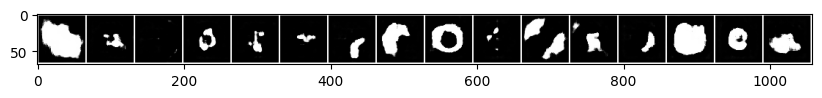

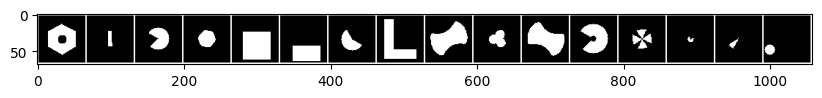

Epoch 11/500 | G: -0.0543 | D: -9.8118 | S: 0.0376
Epoch 12/500 | G: -0.0949 | D: -10.3190 | S: 0.0380
Epoch 13/500 | G: -0.0444 | D: -10.7533 | S: 0.0379
Epoch 14/500 | G: 0.0127 | D: -11.1547 | S: 0.0395
Epoch 15/500 | G: 0.1058 | D: -11.8751 | S: 0.0391
Epoch 16/500 | G: 0.1236 | D: -12.5080 | S: 0.0393
Epoch 17/500 | G: 0.1038 | D: -12.8303 | S: 0.0391
Epoch 18/500 | G: 0.1086 | D: -13.2031 | S: 0.0392
Epoch 19/500 | G: 0.0993 | D: -13.7523 | S: 0.0395
Epoch 20/500 | G: 0.1019 | D: -14.2338 | S: 0.0390


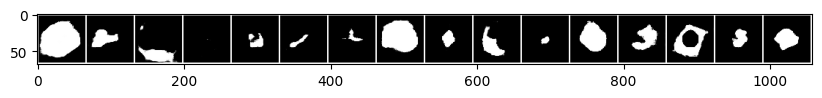

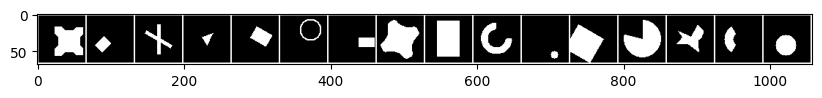

Epoch 21/500 | G: 0.1014 | D: -14.5028 | S: 0.0399
Epoch 22/500 | G: 0.1531 | D: -14.8650 | S: 0.0391
Epoch 23/500 | G: 0.1943 | D: -15.3835 | S: 0.0381
Epoch 24/500 | G: 0.2030 | D: -16.0154 | S: 0.0380
Epoch 25/500 | G: 0.2187 | D: -16.4658 | S: 0.0376
Epoch 26/500 | G: 0.1958 | D: -16.6251 | S: 0.0384
Epoch 27/500 | G: 0.1980 | D: -17.0451 | S: 0.0395
Epoch 28/500 | G: 0.1867 | D: -16.9479 | S: 0.0395
Epoch 29/500 | G: 0.2074 | D: -17.5796 | S: 0.0393
Epoch 30/500 | G: 0.2211 | D: -17.7970 | S: 0.0391


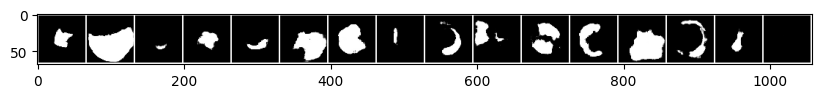

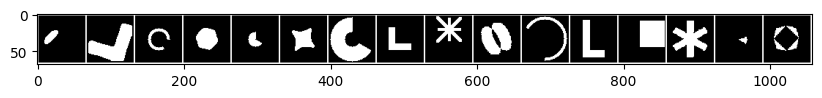

Epoch 31/500 | G: 0.2813 | D: -17.7463 | S: 0.0384
Epoch 32/500 | G: 0.2618 | D: -18.1249 | S: 0.0385
Epoch 33/500 | G: 0.2702 | D: -18.3354 | S: 0.0393
Epoch 34/500 | G: 0.2812 | D: -18.7805 | S: 0.0379
Epoch 35/500 | G: 0.2701 | D: -19.1043 | S: 0.0380
Epoch 36/500 | G: 0.2645 | D: -19.1457 | S: 0.0371
Epoch 37/500 | G: 0.2603 | D: -19.5025 | S: 0.0374
Epoch 38/500 | G: 0.2391 | D: -19.6535 | S: 0.0378
Epoch 39/500 | G: 0.2454 | D: -19.7445 | S: 0.0381
Epoch 40/500 | G: 0.2432 | D: -20.1535 | S: 0.0381


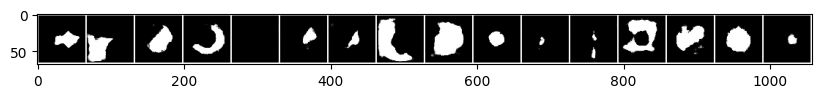

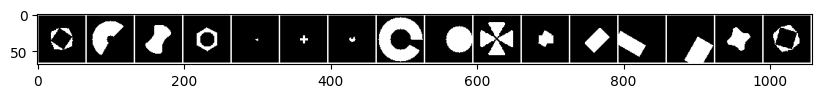

Epoch 41/500 | G: 0.2295 | D: -20.0555 | S: 0.0381
Epoch 42/500 | G: 0.2238 | D: -20.1844 | S: 0.0377
Epoch 43/500 | G: 0.2120 | D: -20.4550 | S: 0.0374
Epoch 44/500 | G: 0.2126 | D: -20.3679 | S: 0.0377
Epoch 45/500 | G: 0.2063 | D: -20.6429 | S: 0.0366
Epoch 46/500 | G: 0.2128 | D: -20.5150 | S: 0.0364
Epoch 47/500 | G: 0.2300 | D: -20.5638 | S: 0.0365
Epoch 48/500 | G: 0.2214 | D: -20.7583 | S: 0.0376
Epoch 49/500 | G: 0.2175 | D: -20.7733 | S: 0.0367
Epoch 50/500 | G: 0.2207 | D: -20.8663 | S: 0.0376


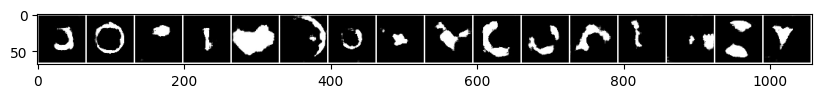

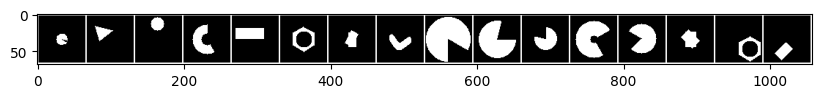

Epoch 51/500 | G: 0.2236 | D: -21.1013 | S: 0.0381
Epoch 52/500 | G: 0.2227 | D: -21.1514 | S: 0.0383
Epoch 53/500 | G: 0.2151 | D: -21.3517 | S: 0.0386
Epoch 54/500 | G: 0.2219 | D: -21.3792 | S: 0.0376
Epoch 55/500 | G: 0.2185 | D: -21.3772 | S: 0.0381
Epoch 56/500 | G: 0.2153 | D: -21.4149 | S: 0.0375
Epoch 57/500 | G: 0.2220 | D: -21.3167 | S: 0.0383
Epoch 58/500 | G: 0.2190 | D: -21.5269 | S: 0.0386
Epoch 59/500 | G: 0.2067 | D: -21.2299 | S: 0.0380
Epoch 60/500 | G: 0.2097 | D: -21.2602 | S: 0.0375


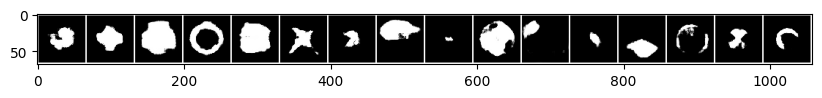

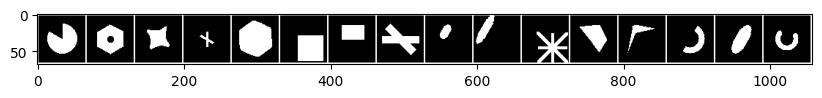

Epoch 61/500 | G: 0.2160 | D: -21.5196 | S: 0.0380
Epoch 62/500 | G: 0.2162 | D: -21.7143 | S: 0.0388
Epoch 63/500 | G: 0.2215 | D: -21.4981 | S: 0.0381
Epoch 64/500 | G: 0.2303 | D: -21.5231 | S: 0.0376
Epoch 65/500 | G: 0.2216 | D: -21.6756 | S: 0.0388
Epoch 66/500 | G: 0.2300 | D: -21.9211 | S: 0.0383
Epoch 67/500 | G: 0.2276 | D: -22.0868 | S: 0.0381
Epoch 68/500 | G: 0.2299 | D: -21.9510 | S: 0.0375
Epoch 69/500 | G: 0.2358 | D: -22.1939 | S: 0.0388
Epoch 70/500 | G: 0.2374 | D: -22.0637 | S: 0.0388


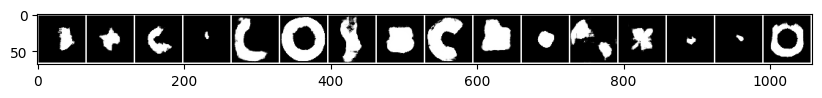

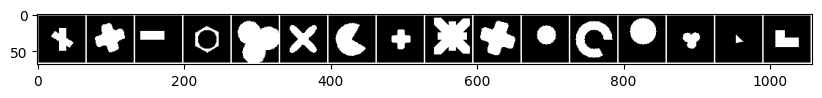

Epoch 71/500 | G: 0.2397 | D: -22.3134 | S: 0.0382
Epoch 72/500 | G: 0.2362 | D: -22.3116 | S: 0.0390
Epoch 73/500 | G: 0.2310 | D: -22.2204 | S: 0.0390
Epoch 74/500 | G: 0.2279 | D: -22.3928 | S: 0.0380
Epoch 75/500 | G: 0.2288 | D: -22.6524 | S: 0.0377
Epoch 76/500 | G: 0.2259 | D: -22.5571 | S: 0.0375
Epoch 77/500 | G: 0.2256 | D: -22.4968 | S: 0.0385
Epoch 78/500 | G: 0.2228 | D: -22.6143 | S: 0.0377
Epoch 79/500 | G: 0.2292 | D: -22.4540 | S: 0.0373
Epoch 80/500 | G: 0.2292 | D: -22.7146 | S: 0.0381


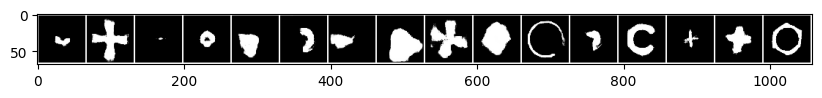

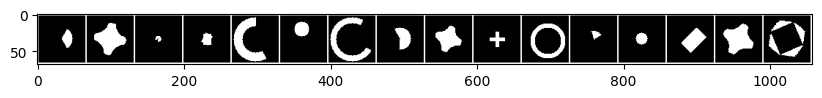

Epoch 81/500 | G: 0.2241 | D: -22.6648 | S: 0.0370
Epoch 82/500 | G: 0.2251 | D: -22.8695 | S: 0.0374
Epoch 83/500 | G: 0.2256 | D: -22.5754 | S: 0.0376
Epoch 84/500 | G: 0.2294 | D: -22.7818 | S: 0.0380
Epoch 85/500 | G: 0.2234 | D: -22.9759 | S: 0.0376
Epoch 86/500 | G: 0.2243 | D: -22.9542 | S: 0.0373
Epoch 87/500 | G: 0.2219 | D: -23.0747 | S: 0.0366
Epoch 88/500 | G: 0.2248 | D: -22.8901 | S: 0.0354
Epoch 89/500 | G: 0.2262 | D: -22.8747 | S: 0.0378
Epoch 90/500 | G: 0.2252 | D: -22.9774 | S: 0.0366


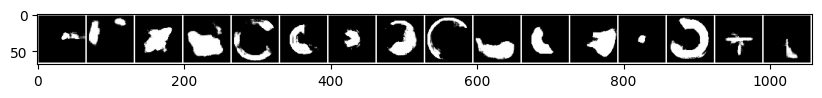

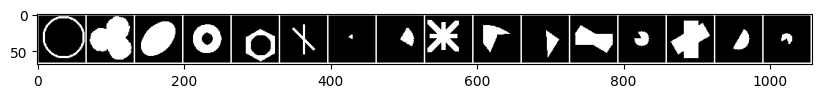

Epoch 91/500 | G: 0.2241 | D: -23.0306 | S: 0.0370
Epoch 92/500 | G: 0.2249 | D: -23.0203 | S: 0.0368
Epoch 93/500 | G: 0.2323 | D: -23.1562 | S: 0.0363
Epoch 94/500 | G: 0.2236 | D: -23.2522 | S: 0.0361
Epoch 95/500 | G: 0.2323 | D: -22.8393 | S: 0.0363
Epoch 96/500 | G: 0.2216 | D: -23.2038 | S: 0.0365
Epoch 97/500 | G: 0.2364 | D: -23.2714 | S: 0.0356
Epoch 98/500 | G: 0.2330 | D: -23.0907 | S: 0.0358
Epoch 99/500 | G: 0.2358 | D: -23.1981 | S: 0.0367
Epoch 100/500 | G: 0.2238 | D: -23.3750 | S: 0.0367


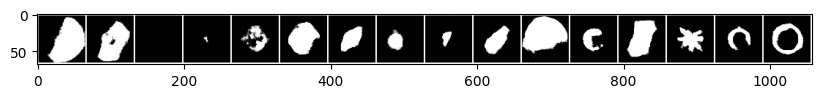

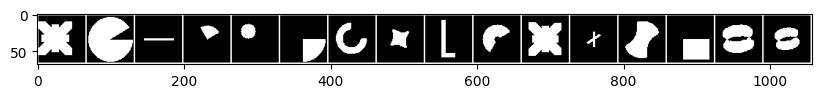

Epoch 101/500 | G: 0.2202 | D: -23.2931 | S: 0.0363
Epoch 102/500 | G: 0.2207 | D: -23.2515 | S: 0.0366
Epoch 103/500 | G: 0.2275 | D: -23.2805 | S: 0.0359
Epoch 104/500 | G: 0.2308 | D: -23.3431 | S: 0.0364
Epoch 105/500 | G: 0.2298 | D: -23.2793 | S: 0.0359
Epoch 106/500 | G: 0.2237 | D: -23.3428 | S: 0.0363
Epoch 107/500 | G: 0.2246 | D: -23.4364 | S: 0.0363
Epoch 108/500 | G: 0.2219 | D: -23.3783 | S: 0.0358
Epoch 109/500 | G: 0.2231 | D: -23.2584 | S: 0.0360
Epoch 110/500 | G: 0.2203 | D: -23.1632 | S: 0.0367


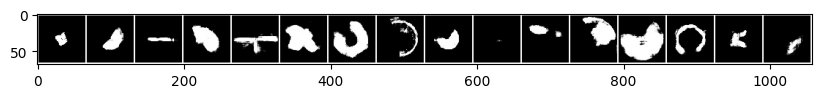

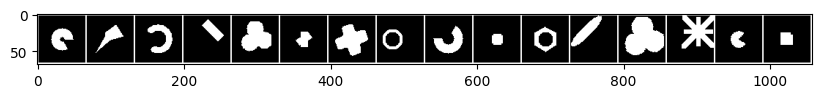

Epoch 111/500 | G: 0.2279 | D: -23.3868 | S: 0.0359
Epoch 112/500 | G: 0.2273 | D: -23.3800 | S: 0.0356
Epoch 113/500 | G: 0.2179 | D: -23.2588 | S: 0.0364
Epoch 114/500 | G: 0.2147 | D: -23.4964 | S: 0.0361
Epoch 115/500 | G: 0.2105 | D: -23.2515 | S: 0.0363
Epoch 116/500 | G: 0.2109 | D: -23.2717 | S: 0.0372
Epoch 117/500 | G: 0.2127 | D: -23.3880 | S: 0.0373
Epoch 118/500 | G: 0.2212 | D: -23.5505 | S: 0.0370
Epoch 119/500 | G: 0.2226 | D: -23.5606 | S: 0.0374
Epoch 120/500 | G: 0.2211 | D: -23.4050 | S: 0.0367


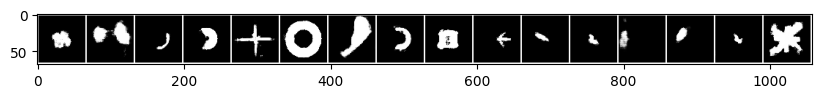

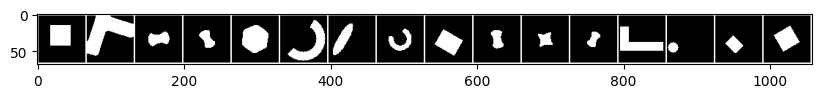

Epoch 121/500 | G: 0.2140 | D: -23.4247 | S: 0.0355
Epoch 122/500 | G: 0.2149 | D: -23.4502 | S: 0.0364
Epoch 123/500 | G: 0.2149 | D: -23.4215 | S: 0.0362
Epoch 124/500 | G: 0.2419 | D: -23.8543 | S: 0.0373
Epoch 125/500 | G: 0.2205 | D: -23.4879 | S: 0.0361
Epoch 126/500 | G: 0.2163 | D: -23.3419 | S: 0.0372
Epoch 127/500 | G: 0.2141 | D: -23.3093 | S: 0.0354
Epoch 128/500 | G: 0.2224 | D: -23.3606 | S: 0.0366
Epoch 129/500 | G: 0.2165 | D: -23.3758 | S: 0.0365
Epoch 130/500 | G: 0.2244 | D: -23.4377 | S: 0.0361


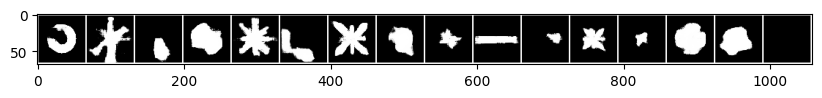

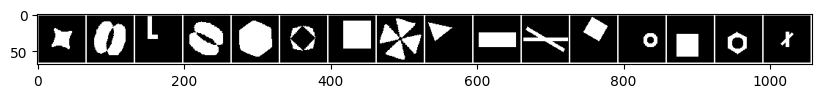

Epoch 131/500 | G: 0.2166 | D: -23.4231 | S: 0.0369
Epoch 132/500 | G: 0.2303 | D: -23.2871 | S: 0.0373
Epoch 133/500 | G: 0.2213 | D: -23.5644 | S: 0.0366
Epoch 134/500 | G: 0.2245 | D: -23.5605 | S: 0.0371
Epoch 135/500 | G: 0.2247 | D: -23.2619 | S: 0.0359
Epoch 136/500 | G: 0.2270 | D: -23.4309 | S: 0.0363
Epoch 137/500 | G: 0.2209 | D: -23.3351 | S: 0.0365
Epoch 138/500 | G: 0.2232 | D: -23.4550 | S: 0.0370
Epoch 139/500 | G: 0.2203 | D: -23.6057 | S: 0.0368
Epoch 140/500 | G: 0.2249 | D: -23.5712 | S: 0.0363


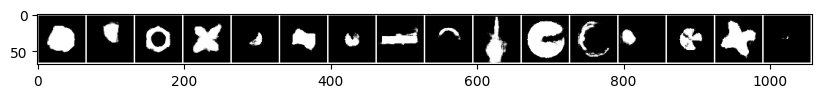

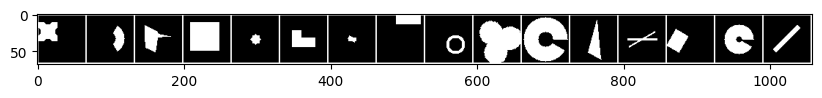

Epoch 141/500 | G: 0.2179 | D: -23.5105 | S: 0.0360
Epoch 142/500 | G: 0.2194 | D: -23.3564 | S: 0.0372
Epoch 143/500 | G: 0.2206 | D: -23.3224 | S: 0.0365
Epoch 144/500 | G: 0.2203 | D: -23.4608 | S: 0.0365
Epoch 145/500 | G: 0.2204 | D: -23.3303 | S: 0.0361
Epoch 146/500 | G: 0.2230 | D: -23.4759 | S: 0.0354
Epoch 147/500 | G: 0.2240 | D: -23.5102 | S: 0.0357
Epoch 148/500 | G: 0.2196 | D: -23.3958 | S: 0.0367
Epoch 149/500 | G: 0.2155 | D: -23.3085 | S: 0.0367
Epoch 150/500 | G: 0.2227 | D: -23.5051 | S: 0.0357


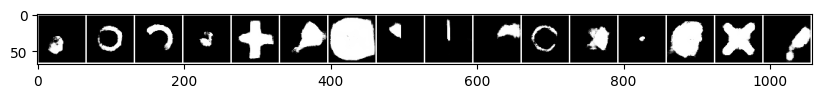

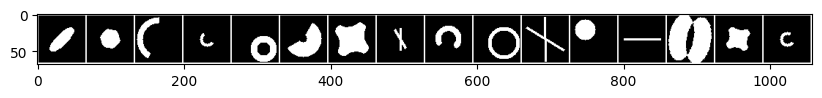

Epoch 151/500 | G: 0.2223 | D: -23.5514 | S: 0.0363
Epoch 152/500 | G: 0.2226 | D: -23.5367 | S: 0.0366
Epoch 153/500 | G: 0.2236 | D: -23.4009 | S: 0.0364
Epoch 154/500 | G: 0.2294 | D: -23.3909 | S: 0.0357
Epoch 155/500 | G: 0.2249 | D: -23.4565 | S: 0.0358
Epoch 156/500 | G: 0.2218 | D: -23.5256 | S: 0.0363
Epoch 157/500 | G: 0.2187 | D: -23.4410 | S: 0.0358
Epoch 158/500 | G: 0.2169 | D: -23.2656 | S: 0.0364
Epoch 159/500 | G: 0.2173 | D: -23.3193 | S: 0.0359
Epoch 160/500 | G: 0.2239 | D: -23.6051 | S: 0.0363


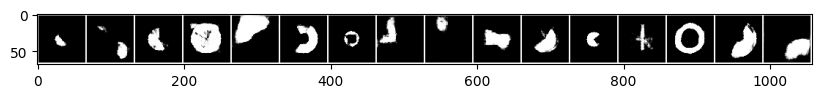

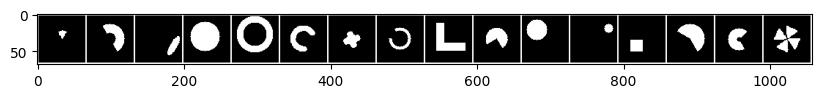

Epoch 161/500 | G: 0.2242 | D: -23.5007 | S: 0.0356
Epoch 162/500 | G: 0.2252 | D: -23.4887 | S: 0.0355
Epoch 163/500 | G: 0.2293 | D: -23.4084 | S: 0.0359
Epoch 164/500 | G: 0.2227 | D: -23.2823 | S: 0.0362
Epoch 165/500 | G: 0.2233 | D: -23.5628 | S: 0.0357
Epoch 166/500 | G: 0.2160 | D: -23.4499 | S: 0.0364
Epoch 167/500 | G: 0.2271 | D: -23.5783 | S: 0.0361
Epoch 168/500 | G: 0.2178 | D: -23.3909 | S: 0.0356
Epoch 169/500 | G: 0.2174 | D: -23.4920 | S: 0.0367
Epoch 170/500 | G: 0.2241 | D: -23.5195 | S: 0.0363


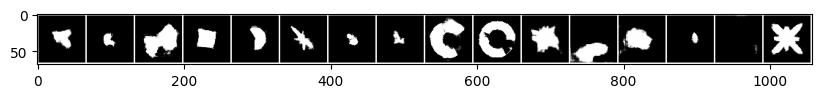

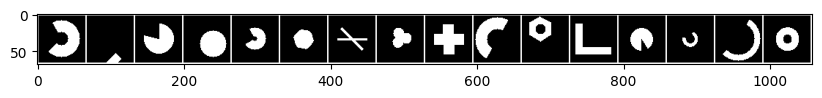

Epoch 171/500 | G: 0.2116 | D: -23.6002 | S: 0.0358
Epoch 172/500 | G: 0.2236 | D: -23.3811 | S: 0.0361
Epoch 173/500 | G: 0.2256 | D: -23.5509 | S: 0.0353
Epoch 174/500 | G: 0.2137 | D: -23.3315 | S: 0.0348
Epoch 175/500 | G: 0.2178 | D: -23.6998 | S: 0.0347
Epoch 176/500 | G: 0.2185 | D: -23.4278 | S: 0.0352
Epoch 177/500 | G: 0.2141 | D: -23.3424 | S: 0.0365
Epoch 178/500 | G: 0.2223 | D: -23.2594 | S: 0.0358
Epoch 179/500 | G: 0.2140 | D: -23.4612 | S: 0.0363
Epoch 180/500 | G: 0.2232 | D: -23.3586 | S: 0.0361


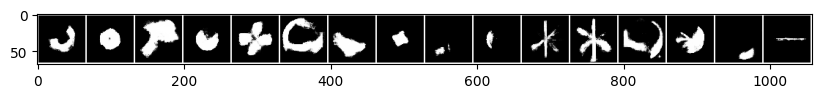

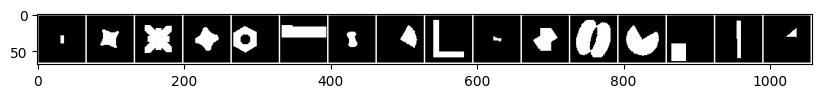

Epoch 181/500 | G: 0.2106 | D: -23.4098 | S: 0.0358
Epoch 182/500 | G: 0.2178 | D: -23.5253 | S: 0.0364
Epoch 183/500 | G: 0.2206 | D: -23.4927 | S: 0.0360
Epoch 184/500 | G: 0.2224 | D: -23.5096 | S: 0.0355
Epoch 185/500 | G: 0.2152 | D: -23.3331 | S: 0.0358
Epoch 186/500 | G: 0.2192 | D: -23.2999 | S: 0.0354
Epoch 187/500 | G: 0.2212 | D: -23.4551 | S: 0.0357
Epoch 188/500 | G: 0.2170 | D: -23.4802 | S: 0.0359
Epoch 189/500 | G: 0.2217 | D: -23.3088 | S: 0.0359
Epoch 190/500 | G: 0.2237 | D: -23.4404 | S: 0.0356


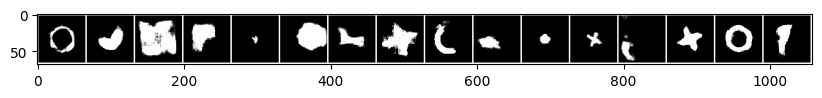

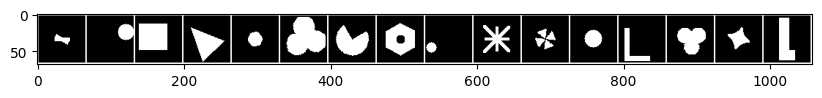

Epoch 191/500 | G: 0.2221 | D: -23.3129 | S: 0.0348
Epoch 192/500 | G: 0.2303 | D: -23.4124 | S: 0.0354
Epoch 193/500 | G: 0.2204 | D: -23.3834 | S: 0.0363
Epoch 194/500 | G: 0.2203 | D: -23.2343 | S: 0.0351
Epoch 195/500 | G: 0.2160 | D: -23.4957 | S: 0.0350
Epoch 196/500 | G: 0.2255 | D: -23.3841 | S: 0.0357
Epoch 197/500 | G: 0.2220 | D: -23.6442 | S: 0.0350
Epoch 198/500 | G: 0.2234 | D: -23.3910 | S: 0.0350
Epoch 199/500 | G: 0.2177 | D: -23.4226 | S: 0.0362
Epoch 200/500 | G: 0.2169 | D: -23.2769 | S: 0.0362


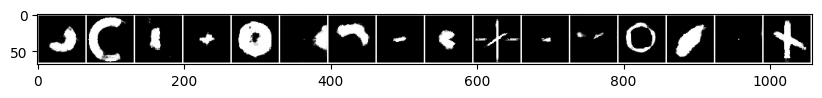

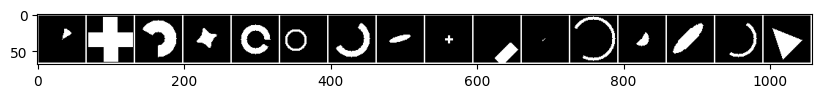

Epoch 201/500 | G: 0.2162 | D: -23.3279 | S: 0.0360
Epoch 202/500 | G: 0.2145 | D: -23.3195 | S: 0.0349
Epoch 203/500 | G: 0.2211 | D: -23.3048 | S: 0.0356
Epoch 204/500 | G: 0.2162 | D: -23.2624 | S: 0.0359
Epoch 205/500 | G: 0.2146 | D: -23.3333 | S: 0.0358
Epoch 206/500 | G: 0.2088 | D: -23.1050 | S: 0.0358
Epoch 207/500 | G: 0.2135 | D: -23.4001 | S: 0.0358
Epoch 208/500 | G: 0.2191 | D: -23.3426 | S: 0.0360
Epoch 209/500 | G: 0.2201 | D: -23.3141 | S: 0.0363
Epoch 210/500 | G: 0.2078 | D: -23.1389 | S: 0.0355


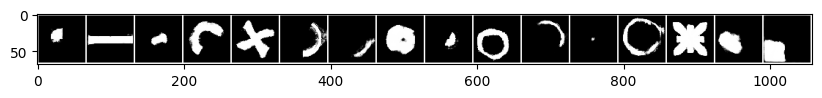

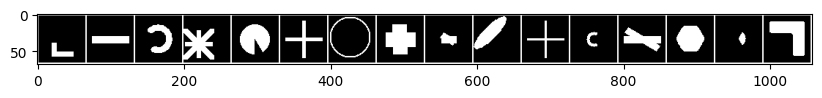

Epoch 211/500 | G: 0.2201 | D: -23.4387 | S: 0.0353
Epoch 212/500 | G: 0.2198 | D: -23.2437 | S: 0.0359
Epoch 213/500 | G: 0.2209 | D: -23.2615 | S: 0.0355
Epoch 214/500 | G: 0.2116 | D: -23.2126 | S: 0.0358
Epoch 215/500 | G: 0.2236 | D: -23.3719 | S: 0.0352
Epoch 216/500 | G: 0.2216 | D: -23.1994 | S: 0.0356
Epoch 217/500 | G: 0.2192 | D: -23.1584 | S: 0.0358
Epoch 218/500 | G: 0.2205 | D: -23.1759 | S: 0.0360
Epoch 219/500 | G: 0.2162 | D: -23.3332 | S: 0.0360
Epoch 220/500 | G: 0.2163 | D: -23.2909 | S: 0.0361


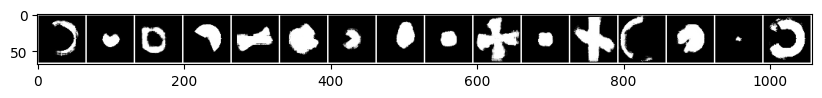

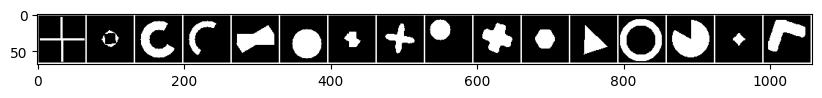

Epoch 221/500 | G: 0.2204 | D: -22.9662 | S: 0.0360
Epoch 222/500 | G: 0.2195 | D: -23.4125 | S: 0.0347
Epoch 223/500 | G: 0.2180 | D: -23.1574 | S: 0.0347
Epoch 224/500 | G: 0.2182 | D: -23.2039 | S: 0.0368
Epoch 225/500 | G: 0.2152 | D: -23.2926 | S: 0.0362
Epoch 226/500 | G: 0.2142 | D: -23.2424 | S: 0.0358
Epoch 227/500 | G: 0.2155 | D: -23.1047 | S: 0.0366
Epoch 228/500 | G: 0.2203 | D: -23.2968 | S: 0.0361
Epoch 229/500 | G: 0.2215 | D: -23.2836 | S: 0.0356
Epoch 230/500 | G: 0.2195 | D: -23.3105 | S: 0.0354


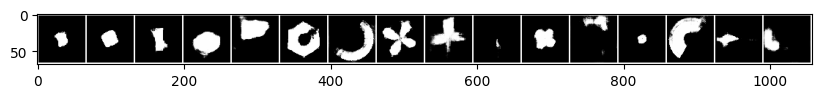

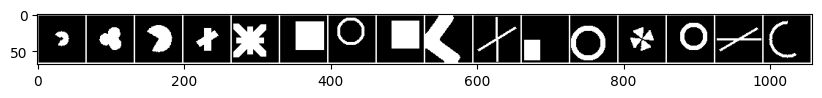

Epoch 231/500 | G: 0.2136 | D: -22.9839 | S: 0.0360
Epoch 232/500 | G: 0.2145 | D: -23.1116 | S: 0.0369
Epoch 233/500 | G: 0.2154 | D: -23.1703 | S: 0.0353
Epoch 234/500 | G: 0.2168 | D: -23.0740 | S: 0.0353
Epoch 235/500 | G: 0.2144 | D: -23.1858 | S: 0.0356
Epoch 236/500 | G: 0.2166 | D: -23.0951 | S: 0.0356
Epoch 237/500 | G: 0.2146 | D: -23.1555 | S: 0.0355
Epoch 238/500 | G: 0.2159 | D: -23.1039 | S: 0.0358
Epoch 239/500 | G: 0.2187 | D: -23.1218 | S: 0.0355
Epoch 240/500 | G: 0.2152 | D: -23.1751 | S: 0.0361


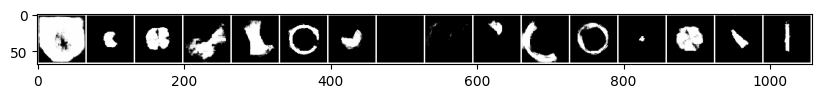

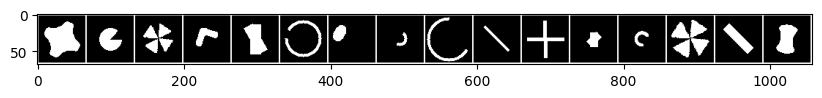

Epoch 241/500 | G: 0.2154 | D: -23.0904 | S: 0.0353
Epoch 242/500 | G: 0.2157 | D: -23.1241 | S: 0.0350
Epoch 243/500 | G: 0.2154 | D: -22.9728 | S: 0.0351
Epoch 244/500 | G: 0.2130 | D: -23.0780 | S: 0.0359
Epoch 245/500 | G: 0.2211 | D: -23.0382 | S: 0.0357
Epoch 246/500 | G: 0.2134 | D: -23.1991 | S: 0.0367
Epoch 247/500 | G: 0.2189 | D: -23.0719 | S: 0.0359
Epoch 248/500 | G: 0.2193 | D: -23.2344 | S: 0.0356
Epoch 249/500 | G: 0.2194 | D: -23.2225 | S: 0.0362
Epoch 250/500 | G: 0.2125 | D: -23.1297 | S: 0.0364


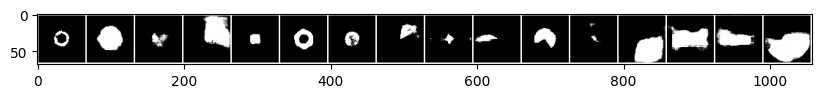

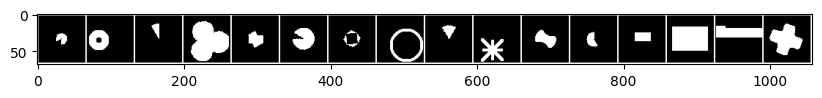

Epoch 251/500 | G: 0.2173 | D: -23.1943 | S: 0.0353
Epoch 252/500 | G: 0.2168 | D: -22.9700 | S: 0.0354
Epoch 253/500 | G: 0.2248 | D: -23.1786 | S: 0.0365
Epoch 254/500 | G: 0.2099 | D: -22.9923 | S: 0.0356
Epoch 255/500 | G: 0.2179 | D: -22.9099 | S: 0.0354
Epoch 256/500 | G: 0.2158 | D: -22.9991 | S: 0.0353
Epoch 257/500 | G: 0.2130 | D: -22.9135 | S: 0.0352
Epoch 258/500 | G: 0.2144 | D: -22.9696 | S: 0.0359
Epoch 259/500 | G: 0.2154 | D: -23.0390 | S: 0.0362
Epoch 260/500 | G: 0.2111 | D: -22.8874 | S: 0.0359


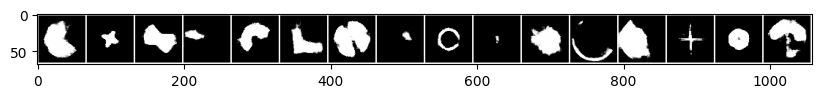

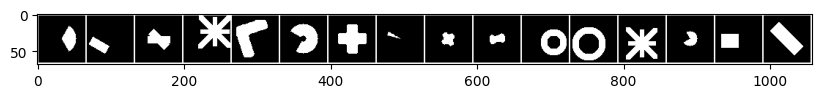

Epoch 261/500 | G: 0.2152 | D: -22.9021 | S: 0.0357
Epoch 262/500 | G: 0.2118 | D: -22.9611 | S: 0.0350
Epoch 263/500 | G: 0.2146 | D: -22.9713 | S: 0.0359
Epoch 264/500 | G: 0.2165 | D: -23.0281 | S: 0.0358
Epoch 265/500 | G: 0.2179 | D: -23.0493 | S: 0.0354
Epoch 266/500 | G: 0.2096 | D: -23.0996 | S: 0.0368
Epoch 267/500 | G: 0.2124 | D: -23.0137 | S: 0.0354
Epoch 268/500 | G: 0.2103 | D: -23.1084 | S: 0.0358
Epoch 269/500 | G: 0.2082 | D: -22.9731 | S: 0.0353
Epoch 270/500 | G: 0.2076 | D: -22.9942 | S: 0.0352


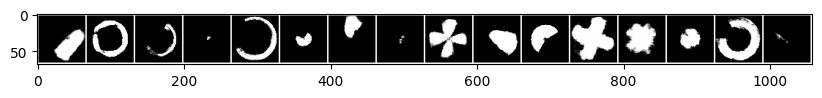

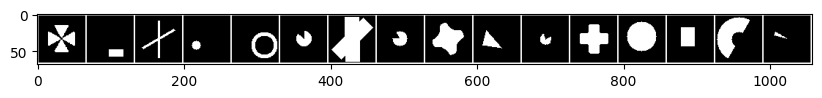

Epoch 271/500 | G: 0.2050 | D: -22.8075 | S: 0.0351
Epoch 272/500 | G: 0.2054 | D: -22.8256 | S: 0.0355
Epoch 273/500 | G: 0.2153 | D: -23.0935 | S: 0.0352
Epoch 274/500 | G: 0.1968 | D: -22.9707 | S: 0.0361
Epoch 275/500 | G: 0.2147 | D: -22.8975 | S: 0.0356
Epoch 276/500 | G: 0.2058 | D: -22.8780 | S: 0.0360
Epoch 277/500 | G: 0.2082 | D: -23.1458 | S: 0.0357
Epoch 278/500 | G: 0.2119 | D: -23.1824 | S: 0.0357
Epoch 279/500 | G: 0.2154 | D: -22.9847 | S: 0.0355
Epoch 280/500 | G: 0.2060 | D: -23.1297 | S: 0.0370


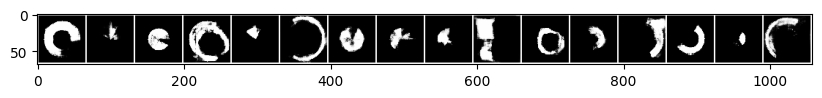

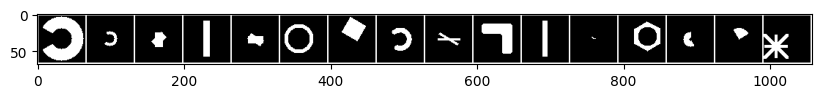

Epoch 281/500 | G: 0.2043 | D: -22.9605 | S: 0.0360
Epoch 282/500 | G: 0.1997 | D: -22.8124 | S: 0.0359
Epoch 283/500 | G: 0.2000 | D: -22.8613 | S: 0.0351
Epoch 284/500 | G: 0.1961 | D: -22.7765 | S: 0.0354
Epoch 285/500 | G: 0.2014 | D: -22.9796 | S: 0.0354
Epoch 286/500 | G: 0.2040 | D: -22.9200 | S: 0.0362
Epoch 287/500 | G: 0.2029 | D: -22.8083 | S: 0.0363
Epoch 288/500 | G: 0.2055 | D: -22.8992 | S: 0.0361
Epoch 289/500 | G: 0.2091 | D: -23.0182 | S: 0.0355
Epoch 290/500 | G: 0.2027 | D: -22.8696 | S: 0.0354


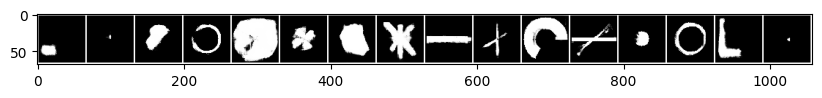

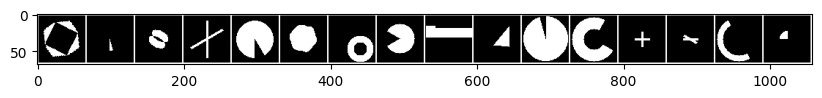

Epoch 291/500 | G: 0.2130 | D: -22.8921 | S: 0.0351
Epoch 292/500 | G: 0.2053 | D: -22.8727 | S: 0.0351
Epoch 293/500 | G: 0.2113 | D: -22.8790 | S: 0.0363
Epoch 294/500 | G: 0.2086 | D: -22.9734 | S: 0.0351
Epoch 295/500 | G: 0.2021 | D: -22.9115 | S: 0.0351
Epoch 296/500 | G: 0.2060 | D: -22.8381 | S: 0.0357
Epoch 297/500 | G: 0.2102 | D: -22.9074 | S: 0.0353
Epoch 298/500 | G: 0.2121 | D: -23.0275 | S: 0.0358
Epoch 299/500 | G: 0.2083 | D: -22.9928 | S: 0.0354
Epoch 300/500 | G: 0.2077 | D: -22.8701 | S: 0.0352


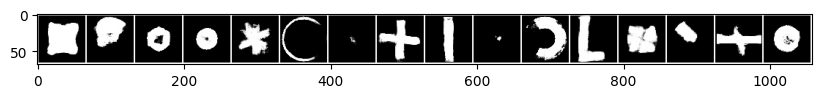

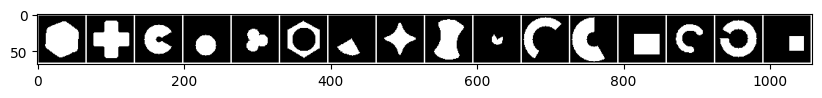

Epoch 301/500 | G: 0.2097 | D: -22.7764 | S: 0.0343
Epoch 302/500 | G: 0.2116 | D: -22.8984 | S: 0.0351
Epoch 303/500 | G: 0.2061 | D: -22.9239 | S: 0.0352
Epoch 304/500 | G: 0.2104 | D: -22.9162 | S: 0.0346
Epoch 305/500 | G: 0.2108 | D: -22.8451 | S: 0.0352
Epoch 306/500 | G: 0.2045 | D: -22.8495 | S: 0.0352
Epoch 307/500 | G: 0.2056 | D: -22.8104 | S: 0.0353
Epoch 308/500 | G: 0.2035 | D: -22.8038 | S: 0.0358
Epoch 309/500 | G: 0.2030 | D: -22.7730 | S: 0.0360
Epoch 310/500 | G: 0.1989 | D: -22.8302 | S: 0.0351


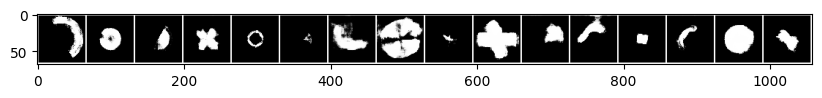

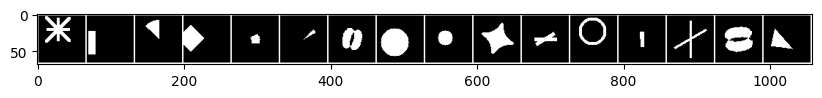

Epoch 311/500 | G: 0.2034 | D: -22.9180 | S: 0.0355
Epoch 312/500 | G: 0.2016 | D: -22.9603 | S: 0.0350
Epoch 313/500 | G: 0.2045 | D: -22.8836 | S: 0.0351
Epoch 314/500 | G: 0.2018 | D: -22.8096 | S: 0.0356
Epoch 315/500 | G: 0.2109 | D: -22.7254 | S: 0.0354
Epoch 316/500 | G: 0.2068 | D: -22.8716 | S: 0.0355
Epoch 317/500 | G: 0.2052 | D: -22.8854 | S: 0.0360
Epoch 318/500 | G: 0.2092 | D: -22.6589 | S: 0.0353
Epoch 319/500 | G: 0.2169 | D: -22.7838 | S: 0.0351
Epoch 320/500 | G: 0.2055 | D: -22.7168 | S: 0.0354


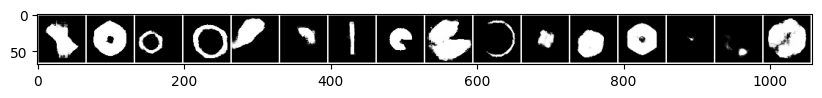

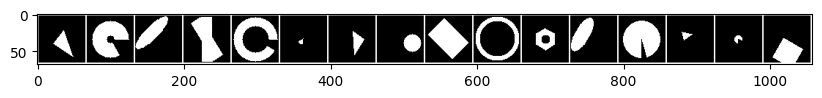

Epoch 321/500 | G: 0.2011 | D: -22.8746 | S: 0.0359
Epoch 322/500 | G: 0.2061 | D: -22.8335 | S: 0.0355
Epoch 323/500 | G: 0.2082 | D: -22.7761 | S: 0.0357
Epoch 324/500 | G: 0.2163 | D: -22.7733 | S: 0.0361
Epoch 325/500 | G: 0.2037 | D: -22.6522 | S: 0.0358
Epoch 326/500 | G: 0.2082 | D: -22.7458 | S: 0.0358
Epoch 327/500 | G: 0.2033 | D: -22.7709 | S: 0.0358
Epoch 328/500 | G: 0.2075 | D: -22.7754 | S: 0.0352
Epoch 329/500 | G: 0.2104 | D: -22.7794 | S: 0.0362
Epoch 330/500 | G: 0.2086 | D: -22.5559 | S: 0.0351


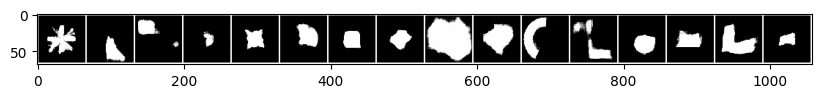

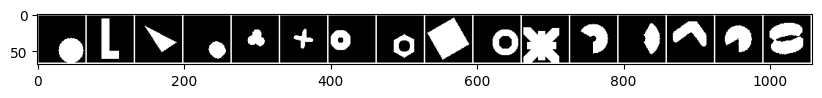

Epoch 331/500 | G: 0.2166 | D: -22.6726 | S: 0.0362
Epoch 332/500 | G: 0.2135 | D: -22.6737 | S: 0.0368
Epoch 333/500 | G: 0.2100 | D: -22.8255 | S: 0.0365
Epoch 334/500 | G: 0.2134 | D: -22.7578 | S: 0.0362
Epoch 335/500 | G: 0.2205 | D: -22.7466 | S: 0.0360
Epoch 336/500 | G: 0.2096 | D: -22.7974 | S: 0.0356
Epoch 337/500 | G: 0.2179 | D: -22.8543 | S: 0.0356
Epoch 338/500 | G: 0.2153 | D: -22.7377 | S: 0.0358
Epoch 339/500 | G: 0.2152 | D: -22.6422 | S: 0.0362
Epoch 340/500 | G: 0.2123 | D: -22.8485 | S: 0.0357


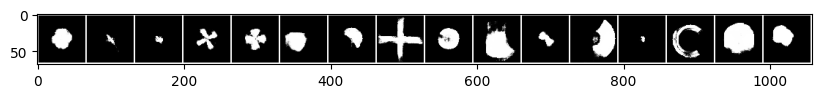

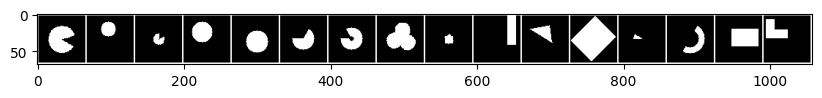

Epoch 341/500 | G: 0.2158 | D: -22.9203 | S: 0.0363
Epoch 342/500 | G: 0.2156 | D: -22.8920 | S: 0.0358
Epoch 343/500 | G: 0.2237 | D: -22.8395 | S: 0.0356
Epoch 344/500 | G: 0.2168 | D: -22.7205 | S: 0.0359
Epoch 345/500 | G: 0.2141 | D: -22.7390 | S: 0.0364
Epoch 346/500 | G: 0.2185 | D: -22.6936 | S: 0.0363
Epoch 347/500 | G: 0.2162 | D: -22.6850 | S: 0.0360
Epoch 348/500 | G: 0.2203 | D: -22.6842 | S: 0.0364
Epoch 349/500 | G: 0.2173 | D: -22.6587 | S: 0.0359
Epoch 350/500 | G: 0.2170 | D: -22.5486 | S: 0.0353


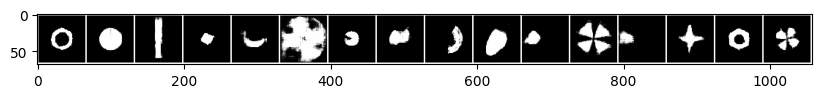

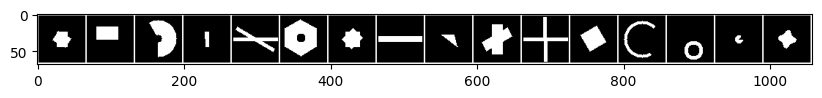

Epoch 351/500 | G: 0.2173 | D: -22.6716 | S: 0.0361
Epoch 352/500 | G: 0.2229 | D: -22.6803 | S: 0.0364
Epoch 353/500 | G: 0.2239 | D: -22.6873 | S: 0.0361
Epoch 354/500 | G: 0.2237 | D: -22.6791 | S: 0.0356
Epoch 355/500 | G: 0.2113 | D: -22.6518 | S: 0.0358
Epoch 356/500 | G: 0.2205 | D: -22.7177 | S: 0.0363
Epoch 357/500 | G: 0.2189 | D: -22.6537 | S: 0.0361
Epoch 358/500 | G: 0.2225 | D: -22.5570 | S: 0.0354
Epoch 359/500 | G: 0.2193 | D: -22.5754 | S: 0.0350
Epoch 360/500 | G: 0.2213 | D: -22.5699 | S: 0.0358


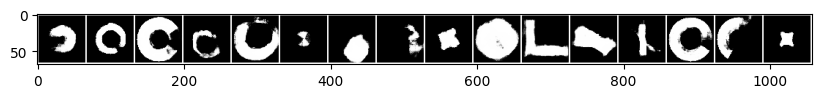

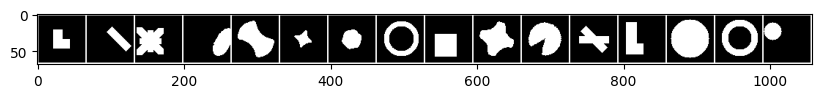

Epoch 361/500 | G: 0.2208 | D: -22.4290 | S: 0.0357
Epoch 362/500 | G: 0.2232 | D: -22.6062 | S: 0.0361
Epoch 363/500 | G: 0.2230 | D: -22.5974 | S: 0.0357
Epoch 364/500 | G: 0.2246 | D: -22.5633 | S: 0.0355
Epoch 365/500 | G: 0.2298 | D: -22.7329 | S: 0.0359
Epoch 366/500 | G: 0.2254 | D: -22.6423 | S: 0.0355
Epoch 367/500 | G: 0.2232 | D: -22.6292 | S: 0.0362
Epoch 368/500 | G: 0.2291 | D: -22.6123 | S: 0.0363
Epoch 369/500 | G: 0.2256 | D: -22.6443 | S: 0.0361
Epoch 370/500 | G: 0.2253 | D: -22.7189 | S: 0.0359


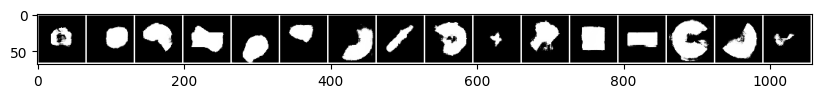

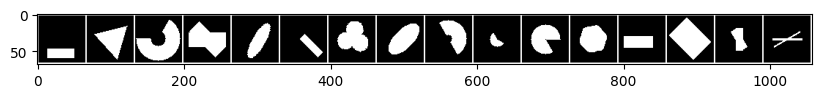

Epoch 371/500 | G: 0.2211 | D: -22.4946 | S: 0.0361
Epoch 372/500 | G: 0.2254 | D: -22.6592 | S: 0.0360
Epoch 373/500 | G: 0.2322 | D: -22.6194 | S: 0.0361
Epoch 374/500 | G: 0.2249 | D: -22.5546 | S: 0.0360
Epoch 375/500 | G: 0.2339 | D: -22.4907 | S: 0.0362
Epoch 376/500 | G: 0.2372 | D: -22.7123 | S: 0.0350
Epoch 377/500 | G: 0.2307 | D: -22.6559 | S: 0.0349
Epoch 378/500 | G: 0.2321 | D: -22.4836 | S: 0.0352
Epoch 379/500 | G: 0.2369 | D: -22.6259 | S: 0.0360
Epoch 380/500 | G: 0.2354 | D: -22.5649 | S: 0.0353


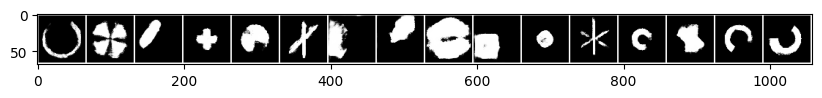

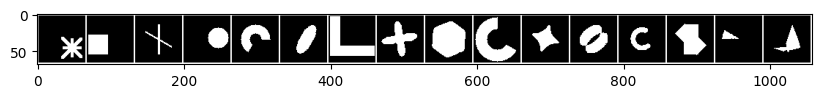

Epoch 381/500 | G: 0.2331 | D: -22.5928 | S: 0.0357
Epoch 382/500 | G: 0.2327 | D: -22.5629 | S: 0.0358
Epoch 383/500 | G: 0.2371 | D: -22.6595 | S: 0.0366
Epoch 384/500 | G: 0.2365 | D: -22.5227 | S: 0.0366
Epoch 385/500 | G: 0.2315 | D: -22.4189 | S: 0.0357
Epoch 386/500 | G: 0.2420 | D: -22.5977 | S: 0.0358
Epoch 387/500 | G: 0.2353 | D: -22.5093 | S: 0.0357
Epoch 388/500 | G: 0.2362 | D: -22.4932 | S: 0.0353
Epoch 389/500 | G: 0.2442 | D: -22.5056 | S: 0.0358
Epoch 390/500 | G: 0.2467 | D: -22.5481 | S: 0.0358


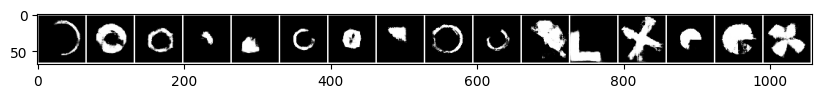

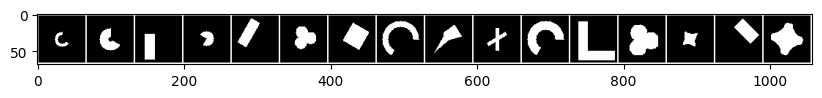

Epoch 391/500 | G: 0.2509 | D: -22.5436 | S: 0.0357
Epoch 392/500 | G: 0.2500 | D: -22.5042 | S: 0.0356
Epoch 393/500 | G: 0.2545 | D: -22.4670 | S: 0.0357
Epoch 394/500 | G: 0.2541 | D: -22.6390 | S: 0.0364
Epoch 395/500 | G: 0.2533 | D: -22.6327 | S: 0.0362
Epoch 396/500 | G: 0.2525 | D: -22.5158 | S: 0.0358
Epoch 397/500 | G: 0.2512 | D: -22.4837 | S: 0.0361
Epoch 398/500 | G: 0.2542 | D: -22.5794 | S: 0.0361
Epoch 399/500 | G: 0.2509 | D: -22.3586 | S: 0.0362
Epoch 400/500 | G: 0.2569 | D: -22.4790 | S: 0.0365


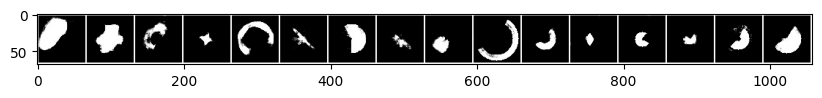

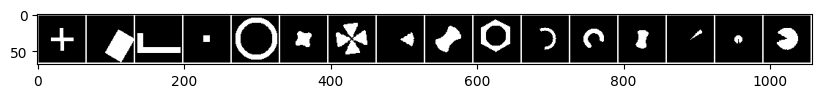

Epoch 401/500 | G: 0.2600 | D: -22.5380 | S: 0.0354
Epoch 402/500 | G: 0.2608 | D: -22.6125 | S: 0.0363
Epoch 403/500 | G: 0.2622 | D: -22.4238 | S: 0.0365
Epoch 404/500 | G: 0.2644 | D: -22.3766 | S: 0.0361
Epoch 405/500 | G: 0.2678 | D: -22.5560 | S: 0.0352
Epoch 406/500 | G: 0.2680 | D: -22.3609 | S: 0.0357
Epoch 407/500 | G: 0.2663 | D: -22.5199 | S: 0.0361
Epoch 408/500 | G: 0.2735 | D: -22.5354 | S: 0.0360
Epoch 409/500 | G: 0.2696 | D: -22.4299 | S: 0.0356
Epoch 410/500 | G: 0.2706 | D: -22.3836 | S: 0.0356


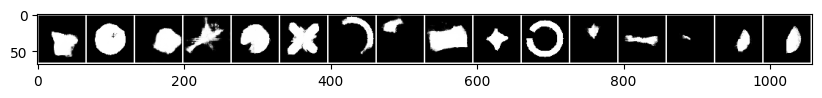

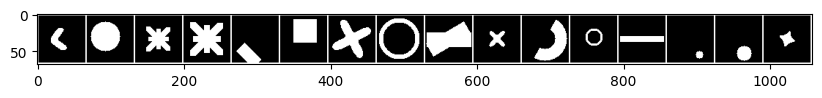

Epoch 411/500 | G: 0.2698 | D: -22.5276 | S: 0.0355
Epoch 412/500 | G: 0.2702 | D: -22.3615 | S: 0.0362
Epoch 413/500 | G: 0.2772 | D: -22.4637 | S: 0.0367
Epoch 414/500 | G: 0.2776 | D: -22.4141 | S: 0.0362
Epoch 415/500 | G: 0.2726 | D: -22.5016 | S: 0.0364
Epoch 416/500 | G: 0.2739 | D: -22.4134 | S: 0.0354
Epoch 417/500 | G: 0.2749 | D: -22.3267 | S: 0.0357
Epoch 418/500 | G: 0.2701 | D: -22.3839 | S: 0.0355
Epoch 419/500 | G: 0.2738 | D: -22.4438 | S: 0.0358
Epoch 420/500 | G: 0.2725 | D: -22.4573 | S: 0.0359


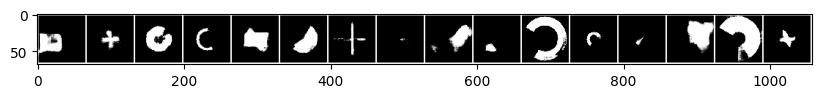

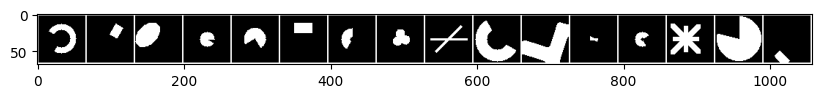

Epoch 421/500 | G: 0.2690 | D: -22.4385 | S: 0.0359
Epoch 422/500 | G: 0.2763 | D: -22.4462 | S: 0.0356
Epoch 423/500 | G: 0.2679 | D: -22.5592 | S: 0.0355
Epoch 424/500 | G: 0.2829 | D: -22.5109 | S: 0.0348
Epoch 425/500 | G: 0.2728 | D: -22.3730 | S: 0.0363
Epoch 426/500 | G: 0.2753 | D: -22.5780 | S: 0.0362
Epoch 427/500 | G: 0.2693 | D: -22.3384 | S: 0.0354
Epoch 428/500 | G: 0.2744 | D: -22.3067 | S: 0.0355
Epoch 429/500 | G: 0.2747 | D: -22.4713 | S: 0.0355
Epoch 430/500 | G: 0.2829 | D: -22.4291 | S: 0.0359


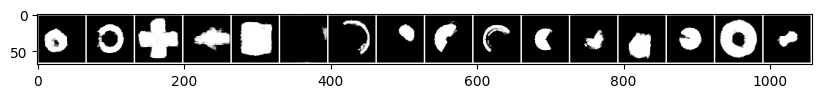

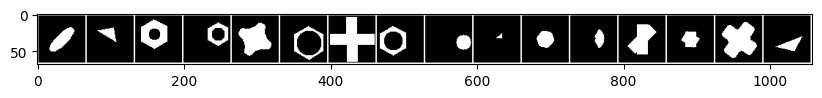

Epoch 431/500 | G: 0.2773 | D: -22.4717 | S: 0.0353
Epoch 432/500 | G: 0.2727 | D: -22.6543 | S: 0.0360
Epoch 433/500 | G: 0.2725 | D: -22.4702 | S: 0.0367
Epoch 434/500 | G: 0.2791 | D: -22.4259 | S: 0.0356
Epoch 435/500 | G: 0.2835 | D: -22.4574 | S: 0.0365
Epoch 436/500 | G: 0.2766 | D: -22.4765 | S: 0.0362
Epoch 437/500 | G: 0.2821 | D: -22.5430 | S: 0.0362
Epoch 438/500 | G: 0.2748 | D: -22.5010 | S: 0.0358
Epoch 439/500 | G: 0.2798 | D: -22.4543 | S: 0.0355
Epoch 440/500 | G: 0.2831 | D: -22.2652 | S: 0.0359


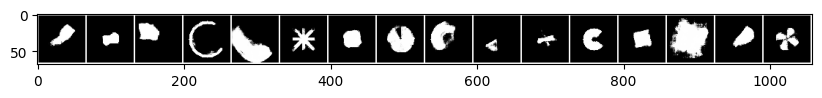

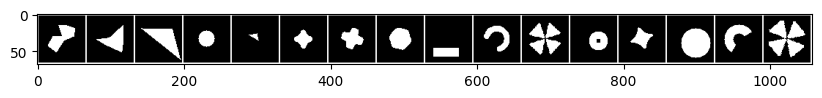

Epoch 441/500 | G: 0.2846 | D: -22.3977 | S: 0.0362
Epoch 442/500 | G: 0.2848 | D: -22.4375 | S: 0.0367
Epoch 443/500 | G: 0.2867 | D: -22.4248 | S: 0.0360
Epoch 444/500 | G: 0.2788 | D: -22.3311 | S: 0.0358
Epoch 445/500 | G: 0.2844 | D: -22.3586 | S: 0.0350
Epoch 446/500 | G: 0.2874 | D: -22.3711 | S: 0.0354
Epoch 447/500 | G: 0.2818 | D: -22.3339 | S: 0.0355
Epoch 448/500 | G: 0.2862 | D: -22.3112 | S: 0.0358
Epoch 449/500 | G: 0.2904 | D: -22.5509 | S: 0.0358
Epoch 450/500 | G: 0.2793 | D: -22.2574 | S: 0.0362


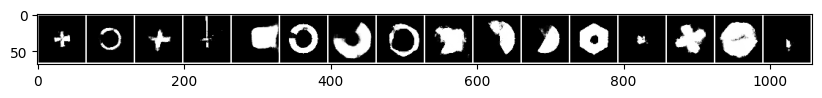

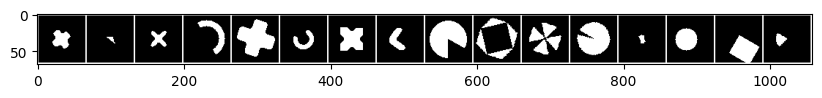

Epoch 451/500 | G: 0.2850 | D: -22.3432 | S: 0.0361
Epoch 452/500 | G: 0.2792 | D: -22.4302 | S: 0.0363
Epoch 453/500 | G: 0.2796 | D: -22.4131 | S: 0.0357
Epoch 454/500 | G: 0.2848 | D: -22.3308 | S: 0.0354
Epoch 455/500 | G: 0.2834 | D: -22.4949 | S: 0.0359
Epoch 456/500 | G: 0.2872 | D: -22.4370 | S: 0.0361
Epoch 457/500 | G: 0.2824 | D: -22.2051 | S: 0.0366
Epoch 458/500 | G: 0.2753 | D: -22.2468 | S: 0.0367
Epoch 459/500 | G: 0.2807 | D: -22.2880 | S: 0.0358
Epoch 460/500 | G: 0.2843 | D: -22.2748 | S: 0.0358


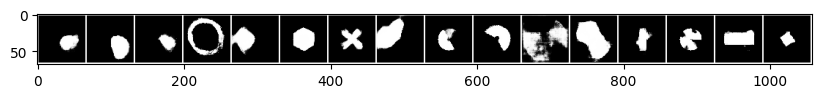

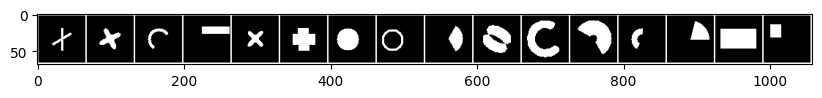

Epoch 461/500 | G: 0.2821 | D: -22.4333 | S: 0.0357
Epoch 462/500 | G: 0.2861 | D: -22.2842 | S: 0.0349
Epoch 463/500 | G: 0.2837 | D: -22.3927 | S: 0.0349
Epoch 464/500 | G: 0.2867 | D: -22.4790 | S: 0.0356
Epoch 465/500 | G: 0.2856 | D: -22.3335 | S: 0.0356
Epoch 466/500 | G: 0.2846 | D: -22.4691 | S: 0.0354
Epoch 467/500 | G: 0.2844 | D: -22.3214 | S: 0.0348
Epoch 468/500 | G: 0.2917 | D: -22.3539 | S: 0.0349
Epoch 469/500 | G: 0.2829 | D: -22.2395 | S: 0.0350
Epoch 470/500 | G: 0.2824 | D: -22.1767 | S: 0.0352


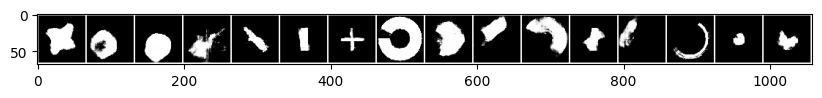

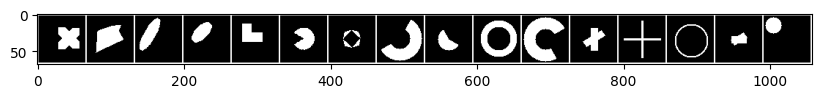

Epoch 471/500 | G: 0.2834 | D: -22.3786 | S: 0.0355
Epoch 472/500 | G: 0.2853 | D: -22.1277 | S: 0.0364
Epoch 473/500 | G: 0.2842 | D: -22.2803 | S: 0.0365
Epoch 474/500 | G: 0.2848 | D: -22.3578 | S: 0.0363
Epoch 475/500 | G: 0.2752 | D: -22.4690 | S: 0.0361
Epoch 476/500 | G: 0.2814 | D: -22.2672 | S: 0.0362
Epoch 477/500 | G: 0.2906 | D: -22.4270 | S: 0.0363
Epoch 478/500 | G: 0.2855 | D: -22.2117 | S: 0.0363
Epoch 479/500 | G: 0.2905 | D: -22.1835 | S: 0.0358
Epoch 480/500 | G: 0.2775 | D: -22.4167 | S: 0.0351


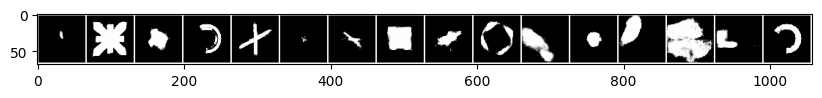

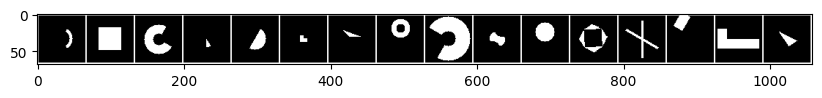

Epoch 481/500 | G: 0.2791 | D: -22.3883 | S: 0.0363
Epoch 482/500 | G: 0.2813 | D: -22.4124 | S: 0.0366
Epoch 483/500 | G: 0.2858 | D: -22.1697 | S: 0.0364
Epoch 484/500 | G: 0.2863 | D: -22.2012 | S: 0.0366
Epoch 485/500 | G: 0.2859 | D: -22.2269 | S: 0.0360
Epoch 486/500 | G: 0.2806 | D: -22.0525 | S: 0.0363
Epoch 487/500 | G: 0.2837 | D: -22.2093 | S: 0.0363
Epoch 488/500 | G: 0.2864 | D: -22.3400 | S: 0.0352
Epoch 489/500 | G: 0.2819 | D: -22.2994 | S: 0.0356
Epoch 490/500 | G: 0.2840 | D: -22.2775 | S: 0.0357


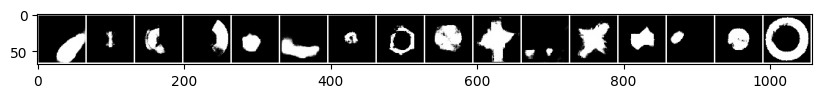

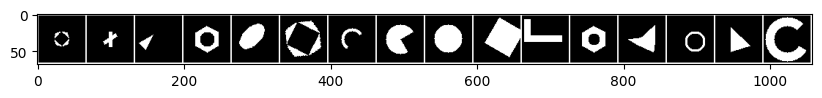

Epoch 491/500 | G: 0.2876 | D: -22.1455 | S: 0.0368
Epoch 492/500 | G: 0.2813 | D: -22.3802 | S: 0.0361
Epoch 493/500 | G: 0.2858 | D: -22.1703 | S: 0.0362
Epoch 494/500 | G: 0.2844 | D: -22.0507 | S: 0.0362
Epoch 495/500 | G: 0.2789 | D: -22.1987 | S: 0.0359
Epoch 496/500 | G: 0.2874 | D: -22.2302 | S: 0.0349
Epoch 497/500 | G: 0.2889 | D: -22.1160 | S: 0.0357
Epoch 498/500 | G: 0.2833 | D: -22.0513 | S: 0.0366
Epoch 499/500 | G: 0.2857 | D: -22.2975 | S: 0.0364
Epoch 500/500 | G: 0.2841 | D: -22.0690 | S: 0.0365


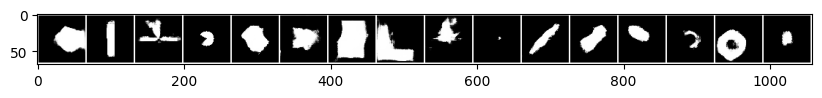

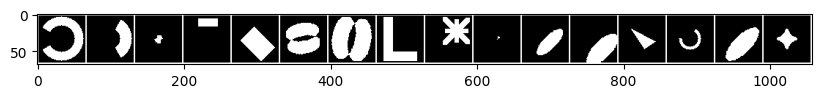

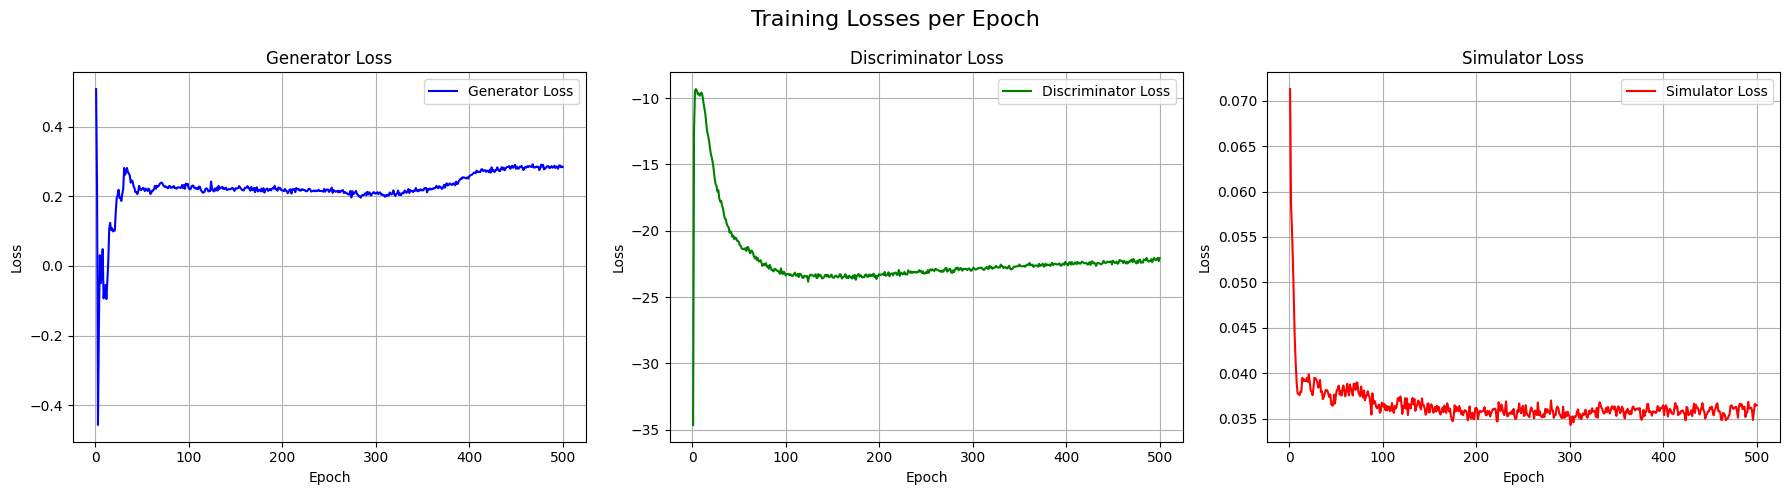

In [5]:
G_losses, D_losses , S_losses= train_wgan(generator, discriminator, simulator, g_optimizer, d_optimizer, train_loader, DEVICE, NUM_EPOCHS, N_CRITIC, noise_dim, c_lambda)

epochs = range(1, len(G_losses) + 1)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 3 subplots side by side

# Generator Loss
axs[0].plot(epochs, G_losses, label="Generator Loss", color='blue')
axs[0].set_title("Generator Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].grid(True)
axs[0].legend()

# Discriminator Loss
axs[1].plot(epochs, D_losses, label="Discriminator Loss", color='green')
axs[1].set_title("Discriminator Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].grid(True)
axs[1].legend()

# Simulator Loss
axs[2].plot(epochs, S_losses, label="Simulator Loss", color='red')
axs[2].set_title("Simulator Loss")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Loss")
axs[2].grid(True)
axs[2].legend()

plt.suptitle("Training Losses per Epoch", fontsize=16)
plt.tight_layout()
plt.show()
